# Data Frames


A `a2rl.WiDataFrame` (and `a2rl.Series`) is the central data structure leveraged by the rest of
`a2rl` library such as simulators, tokenizers, and agents. It is a data frame that represents the
historical *states*, *actions* and *rewards*, possibly with additional context. Each row in the
dataframe denotes a state at a point-in-time, the action taken on that state (& time), and the
rewards of taking that action on that specific state.

A `a2rl.WiDataFrame` can be created from:

- an existing data structure: `pandas.DataFrame`, ndarray (structured or homogeneous), Iterable,
  or dict. See the `data` argument in
  [pandas.DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html).
- a `whatif` dataset, which is a directory comprising of a metadata YAML file, and a CSV data
  file.

**NOTE**: to enable color outputs in the notebook, please install
[rich](https://github.com/Textualize/rich) (e.g., by running `%pip install rich` in your notebook).

In [1]:
%load_ext autoreload
%autoreload 2

from __future__ import annotations
import pandas as pd

import a2rl as wi
from a2rl.nbtools import pprint, print  # Enable color outputs when rich is installed.

/opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/lightning_fabric/__init__.py:36: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('lightning_fabric')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)


/opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/pytorch_lightning/__init__.py:36: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('pytorch_lightning')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  __import__("pkg_resources").declare_namespace(__name__)
/opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/nptyping/typing_.py:51: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  Bool8 = np.bool8
/opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/nptyping/typing_.py:54: DeprecationWarning: `np.object0` is a deprecated alias for ``np.object0` is a deprecated alias for `np.object_`. `object` can be used instead.  (Deprecated NumPy 1.24)`.  (Deprecated NumPy 1.24)
  Object0 = np.object0
/opt/hostedtoolc

## Load Dataset

`whatif` comes with a few sample datasets to jumpstart your experience. You can list the available
sample datasets, resolve the path of a specific sample dataset, and load a sample dataset into a
`WiDataFrame`.

**NOTE**: please see a separate example on how to create a `whatif` dataset.

In [2]:
# List sample datasets
print("Available sample datasets:", wi.list_sample_datasets())

# Get the path to the chiller dataset.
p = wi.sample_dataset_path("chiller")
print("Location of chiller dataset:", repr(p))

# Load dataset to a dataframe
df = wi.read_csv_dataset(p)
pprint("Sar columns:", df.sar_d)
df.head()

Available sample datasets: ['chiller', 'rtu']


Location of chiller dataset: PosixPath('/opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/a2rl/dataset/chiller')


Sar columns:
{
    'states': ['condenser_inlet_temp', 'evaporator_heat_load_rt'],
    'actions': ['staging'],
    'rewards': ['system_power_consumption']
}


timestamp staging  condenser_inlet_temp  evaporator_heat_load_rt   
0  2025-08-01 00:00:00       1                  29.5                    455.4  \
1  2025-08-01 01:00:00       0                  30.2                    913.1   
2  2025-08-01 02:00:00       0                  29.3                    576.2   
3  2025-08-01 03:00:00       4                  28.5                    737.1   
4  2025-08-01 04:00:00      10                  30.3                    784.4   

   system_power_consumption  
0                     756.4  
1                     959.3  
2                     586.1  
3                    1178.5  
4                     880.9

You can see that the chiller dataframe specifies four *expected* sar columns, however the
dataframe itself contains an additional column `timestamp`. This behavior is by-design, intended
to allow you to apply additional preprocessing that require those additional contexts (i.e.,
columns). In this particular chiller example, you might want to resample the dataframe by the
`timestamp` column. Similarly, other operations can be applied.

At some point in time, to train a simulator, you need a dataframe with strictly the *sar* columns
only, which you can achieve by trimming the dataframe.

In [3]:
df_trimmed = df.trim()
df_trimmed.head()

condenser_inlet_temp  evaporator_heat_load_rt staging   
0                  29.5                    455.4       1  \
1                  30.2                    913.1       0   
2                  29.3                    576.2       0   
3                  28.5                    737.1       4   
4                  30.3                    784.4      10   

   system_power_consumption  
0                     756.4  
1                     959.3  
2                     586.1  
3                    1178.5  
4                     880.9

## Construct Data Frame

You can also directly create a `WiDataFrame` from a plain `pandas.DataFrame`, or from any data
source that you can use to create a regular `pandas.DataFrame`. However, `WiDataFrame` requires you
to also supply the *sar* information.

The following cell shows two typical variants to construct `WiDataFrame`: one from a dictionary, and
another `pandas.DataFrame`. Please refer to
[pandas.DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) to learn the
additional types of data sources supported.

You'll notice that the created data frames contains an additional columns, `z`, which is not part
of *sar*. We will explain about this behavior in the next [section](#SAR-Columns).

In [4]:
df_from_dict = wi.WiDataFrame(
    {
        "s1": [1, 2, 3],
        "s2": [3, 4, 5],
        "z": [6, 7, 8],
        "a": ["x", "y", "z"],
        "r": [0.5, 1.5, 2.5],
    },
    states=["s1", "s2"],
    actions=["a"],
    rewards=["r"],
)

display(df_from_dict.sar_d, df_from_dict)

{'states': ['s1', 's2'], 'actions': ['a'], 'rewards': ['r']}

s1  s2  z  a    r
0   1   3  6  x  0.5
1   2   4  7  y  1.5
2   3   5  8  z  2.5

In [5]:
pd_df = pd.DataFrame(
    {
        "s1": [10, 20, 30],
        "s2": [30, 40, 50],
        "z": [60, 70, 80],
        "a": ["X", "Y", "Z"],
        "r": [10.5, 11.5, 12.5],
    },
)

df_from_pd_df = wi.WiDataFrame(
    pd_df,
    states=["s1", "s2"],
    actions=["a"],
    rewards=["r"],
)
display(df_from_pd_df.sar_d, df_from_pd_df)

{'states': ['s1', 's2'], 'actions': ['a'], 'rewards': ['r']}

s1  s2   z  a     r
0  10  30  60  X  10.5
1  20  40  70  Y  11.5
2  30  50  80  Z  12.5

## SAR Information

You can query the *sar* information as follows:

In [6]:
pprint("Sar as dictionary:", df.sar_d, "")
pprint("Sar as list:", df.sar, "")
print("States:", df.states)
print("Actions:", df.actions)
print("Rewards:", df.rewards)

Sar as dictionary:
{
    'states': ['condenser_inlet_temp', 'evaporator_heat_load_rt'],
    'actions': ['staging'],
    'rewards': ['system_power_consumption']
}



Sar as list:
[
    'condenser_inlet_temp',
    'evaporator_heat_load_rt',
    'staging',
    'system_power_consumption'
]



States: ['condenser_inlet_temp', 'evaporator_heat_load_rt']


Actions: ['staging']


Rewards: ['system_power_consumption']


By now, you're already familiar with the key concept that `WiDataFrame` knows what should be its
*sar* columns. However, it does not mean that those columns must really exist in the data frame.
The dataframe itself may contains columns not in *sar* (e.g., the `timestamp` column in the chiller
data), or even none of the *sar* columns at all!

This behavior is by design. The intent is to let you specify only *once* the *sar* information of
your business problem, and let `whatif` to manage and automatically propagate the association
between your historical data and the *sar* information to the rest of `whatif` API.

This design brings a few benefits:

1. you don't need to manually keep track the association between a pandas data frame with your *sar*
   information.
2. you only need to pass around a `WiDataFrame` object instead of always passing both a
   `pandas.DataFrame` and your *sar* information to various `whatif` operations.

Let's illustrate these points with a simplified example which typically happens during
preprocessing: splitting a dataframe into series, do something with the series, then combine the
processed series back to a data frame again.

In [7]:
def assert_same_sar(sers: list[pd.Series]) -> None:
    """Check that all series has the same sar."""
    for ser in sers[1:]:
        if ser.sar != sers[0].sar:
            raise ValueError("Some series have different sar")


# Split the chiller df into 5 series (i.e., 1 for each column)
if pd.__version__ >= "1.5.0":
    sers = [ser for _, ser in df.items()]
else:
    sers = [ser for _, ser in df.iteritems()]
assert_same_sar(sers)

# Scale the states and rewards
cols_to_scale = {*df.states, *df.rewards}
sers = [ser / 25.0 if ser.name in cols_to_scale else ser for ser in sers]
assert_same_sar(sers)

# Show series names, and the common sar inherited from the source dataframe.
pprint("All series have the same sar:", sers[0].sar_d, "")

# Reconstruct to a new df, and notice how the sar property is propagated.
df_joined = pd.concat(sers, axis=1)
pprint("Reconstructed dataframe has these sar:", df_joined.sar_d)
df_joined.head()

All series have the same sar:
{
    'states': ['condenser_inlet_temp', 'evaporator_heat_load_rt'],
    'actions': ['staging'],
    'rewards': ['system_power_consumption']
}



Reconstructed dataframe has these sar:
{
    'states': ['condenser_inlet_temp', 'evaporator_heat_load_rt'],
    'actions': ['staging'],
    'rewards': ['system_power_consumption']
}


timestamp staging  condenser_inlet_temp  evaporator_heat_load_rt   
0  2025-08-01 00:00:00       1                 1.180                   18.216  \
1  2025-08-01 01:00:00       0                 1.208                   36.524   
2  2025-08-01 02:00:00       0                 1.172                   23.048   
3  2025-08-01 03:00:00       4                 1.140                   29.484   
4  2025-08-01 04:00:00      10                 1.212                   31.376   

   system_power_consumption  
0                    30.256  
1                    38.372  
2                    23.444  
3                    47.140  
4                    35.236

## Pandas Operations

You can apply a wide range of pandas operations on `WiDataFrame` and `WiSeries`, just like to their
`pandas` counterpart, and the results will still inherit the *sar* information. In fact, `pandas`
operations applied to `whatif` data structures (i.e., frames and series) results in new `whatif`
data structures.

You've seen [slicing](https://pandas.pydata.org/docs/user_guide/indexing.html) and
[concatenation](https://pandas.pydata.org/docs/user_guide/merging.html#concatenating-objects) in
the previous cell. The next cells demonstrates a few more operations typically used during EDA and
preprocessing. Notice how the *sar* information are propagated throughout the processing chain.

/opt/hostedtoolcache/Python/3.10.11/x64/lib/python3.10/site-packages/matplotlib_inline/config.py:59: DeprecationWarning: InlineBackend._figure_formats_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_formats_changed(self, name, old, new):


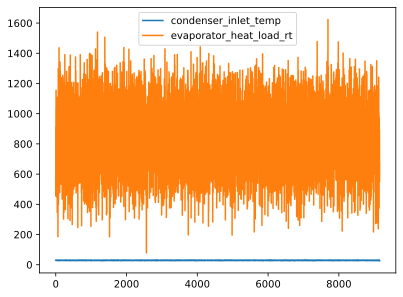

In [8]:
# Plot the states columns
df[df.states].plot();

In [9]:
# Groupby: to compute average reward per action.
df_mean_reward_per_action = df.groupby(df.actions).agg({df.rewards[0]: "mean"})
pprint("Sar information:", df_mean_reward_per_action.sar_d)
df_mean_reward_per_action

Sar information:
{
    'states': ['condenser_inlet_temp', 'evaporator_heat_load_rt'],
    'actions': ['staging'],
    'rewards': ['system_power_consumption']
}


system_power_consumption
staging                          
0                      848.573333
1                      845.397971
10                     843.128897
2                      832.561044
3                      850.013733
4                      853.697105
5                      849.262349
6                      853.764322
7                      848.015867
8                      843.196158
9                      853.612880

## Summary

Congratulations! You've completed the tutorial on `whatif` data frame. We encourage you to further
explore the remaining examples.